# TF-IDF score: Kullback–Leibler divergence

In [1]:
# Change working directory to parent so we can import as we would from main.py
%cd ..

import gc
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import log2
from sklearn.feature_extraction.text import TfidfVectorizer # type: ignore
from scipy.stats import fit, exponnorm, gaussian_kde
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import configuration as config

/mnt/arkk/llm_detector/classifier


Load the training data from the last step with the perpleixty ratio KL score already added.

In [2]:
# Load the data training data
training_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TRAINING_DATA_PR)

# Replace and remove string 'OOM' and 'NAN' values
training_data_df.replace('NAN', np.nan, inplace = True)
training_data_df.replace('OOM', np.nan, inplace = True)
training_data_df.dropna(inplace = True)

# Fix some d-types
training_data_df = training_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12716 entries, 0 to 12715
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  12716 non-null  int64  
 1   Fragment length (tokens)                 12716 non-null  int64  
 2   Dataset                                  12716 non-null  object 
 3   Source                                   12716 non-null  object 
 4   String                                   12716 non-null  object 
 5   Perplexity                               12716 non-null  float64
 6   Cross-perplexity                         12716 non-null  float64
 7   Perplexity ratio score                   12716 non-null  float64
 8   Perplexity ratio Kullback-Leibler score  12716 non-null  float64
dtypes: float64(4), int64(2), object(3)
memory usage: 993.4+ KB


Now, clean up the text fragments for TF-IDF analysis.

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')

sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text: str = None) -> str:
    
    # Lowercase everything
    text = text.lower()

    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",")
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    # Remove URLs 
    text = re.sub(r"http\S+", "",text)
    
    # Remove html tags
    html = re.compile(r'<.*?>') 
    text = html.sub(r'',text)
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'

    # Remove punctuations
    for p in punctuations:
        text = text.replace(p,'')
        
    # Remove stopwords
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
    "]+", flags=re.UNICODE)
    
    text = emoji_pattern.sub(r'', text)
    
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/siderealyear/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Take samples so we dont' OOM during vectorization for TF-IDF
training_data_df_sample = training_data_df.sample(frac = 0.5, random_state = 42)
training_data_df_sample.reset_index(inplace = True, drop = True)

In [5]:
# Get human and synthetic text
human_texts_sample = training_data_df_sample['String'][training_data_df_sample['Source'] == 'human']
synthetic_texts_sample = training_data_df_sample['String'][training_data_df_sample['Source'] == 'synthetic']

In [6]:
# Clean for vectorization
human_texts_sample = human_texts_sample.apply(lambda x: clean_text(x))
synthetic_texts_sample = synthetic_texts_sample.apply(lambda x: clean_text(x))

Now calculate TF-IDF on the human and synthetic text samples.

In [7]:
# Fit the TF-IDF vectorizer
human_tfidf_vectorizer = TfidfVectorizer()
human_tfidf_vectors = human_tfidf_vectorizer.fit_transform(human_texts_sample)

# Convert the vectors to numpy and replace zeros with NAN
human_tfidf = human_tfidf_vectors.toarray()
human_tfidf[human_tfidf == 0] = np.nan

# Take the log2 and average the columns (i.e. get average TF-IDF per word)
log_human_tfidf = np.log2(human_tfidf)
log_human_tfidf_mean = np.nanmean(log_human_tfidf, axis = 0)

# Get the words
human_features = human_tfidf_vectorizer.get_feature_names_out()

# Release some memory
del human_tfidf_vectorizer
del human_tfidf_vectors
gc.collect()


0

In [8]:
# Fit the TF-IDF vectorizer
synthetic_tfidf_vectorizer = TfidfVectorizer() 
synthetic_tfidf_vectors = synthetic_tfidf_vectorizer.fit_transform(synthetic_texts_sample)

# Convert the vectors to numpy and replace zeros with NAN
synthetic_tfidf = synthetic_tfidf_vectors.toarray()
synthetic_tfidf[synthetic_tfidf == 0] = np.nan

# Take the log2 and average the columns (i.e. get average TF-IDF per word)
log_synthetic_tfidf = np.log2(synthetic_tfidf)
log_synthetic_tfidf_mean = np.nanmean(log_synthetic_tfidf, axis = 0)

# Get the words
synthetic_features = synthetic_tfidf_vectorizer.get_feature_names_out()

# Release some memory
del synthetic_tfidf_vectorizer
del synthetic_tfidf_vectors
gc.collect()

0

In [9]:
# Make the look-up tables
tfidf_luts = {
    'human': dict(zip(human_features, log_human_tfidf_mean)),
    'synthetic': dict(zip(synthetic_features, log_synthetic_tfidf_mean))
}

In [10]:
# Score the Hans 2024 text fragments

def score_known_text_fragments(data_df: pd.DataFrame, tfidf_luts: dict = None) -> dict:
    '''Scores text fragments with product normalized difference in
    log2 TF-IDF mean.'''

    # Holders for TF-IDF values
    product_normalized_human_dmean_tfidf = []
    product_normalized_synthetic_dmean_tfidf = []

    # Loop on dataframe rows
    for _, row in data_df.iterrows():
        
        human_tfidf_sum = 0
        synthetic_tfidf_sum = 0

        # Get the text from this row
        text = row['String']

        # Clean the text
        text = clean_text(text)

        # Split the text into words
        words = text.split(' ')

        # Score the words using the human and synthetic luts
        for word in words:

            if word in tfidf_luts['human'].keys():
                human_tfidf_sum += tfidf_luts['human'][word]

            if word in tfidf_luts['synthetic'].keys():
                synthetic_tfidf_sum += tfidf_luts['synthetic'][word]

        # Get the means
        human_tfidf_mean = human_tfidf_sum / len(words)
        synthetic_tfidf_mean = synthetic_tfidf_sum / len(words)
        dmean_tfidf = human_tfidf_mean - synthetic_tfidf_mean
        product_normalized_dmean_tfidf = dmean_tfidf * (human_tfidf_mean + synthetic_tfidf_mean)

        if row['Source'] == 'human':
            product_normalized_human_dmean_tfidf.append(product_normalized_dmean_tfidf)

        elif row['Source'] == 'synthetic':
            product_normalized_synthetic_dmean_tfidf.append(product_normalized_dmean_tfidf)

    return {'human': product_normalized_human_dmean_tfidf, 'synthetic': product_normalized_synthetic_dmean_tfidf}

In [11]:
fragment_scores = score_known_text_fragments(training_data_df, tfidf_luts)

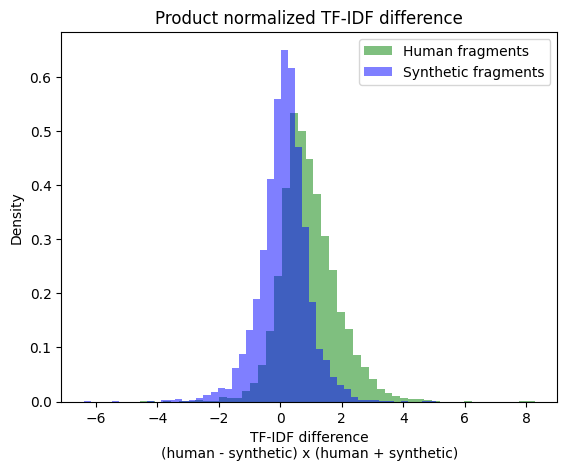

In [12]:
plt.title('Product normalized TF-IDF difference')
plt.hist(fragment_scores['human'], density = True, bins = 50, facecolor = 'green', label = 'Human fragments', alpha = 0.5)
plt.hist(fragment_scores['synthetic'], density = True, bins = 50, facecolor = 'blue', label = 'Synthetic fragments', alpha = 0.5)
plt.xlabel('TF-IDF difference\n(human - synthetic) x (human + synthetic)')
plt.ylabel('Density')
plt.legend(loc = 'upper right')
plt.show()

In [13]:
# Set up bins for the combined dataset
product_normalized_dtfidfs = []
product_normalized_dtfidfs.extend(fragment_scores['human'])
product_normalized_dtfidfs.extend(fragment_scores['synthetic'])

counts, bins = np.histogram(product_normalized_dtfidfs, bins = 100, density = True)

# Get bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Calculate histograms for the human and synthetic data
human_density, human_bins = np.histogram(fragment_scores['human'], bins = bins, density = True)
synthetic_density, synthetic_bins = np.histogram(fragment_scores['synthetic'], bins = bins, density = True)

In [14]:
# Exponential Gaussian
bounds = [[-10.0,10.0],[-10.0,10.0],[-10.0,10.0]]

human_exponnorm = fit(exponnorm, fragment_scores['human'], bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(bin_centers)

synthetic_exponnorm = fit(exponnorm, fragment_scores['synthetic'], bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(bin_centers)

print(f'Human K: {human_exponnorm.params.K}')
print(f'Human loc: {human_exponnorm.params.loc}')
print(f'Human scale: {human_exponnorm.params.scale}')

/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1636: RuntimeWarning: overflow encountered in divide
  x = asarray((x-loc) / scale)
/mnt/arkk/llm_detector/.venv/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1782: RuntimeWarning: overflow encountered in scalar divide
  invK = 1.0 / K


Human K: 0.8474647824159365
Human loc: 0.33616817488134104
Human scale: 0.7040322113439856


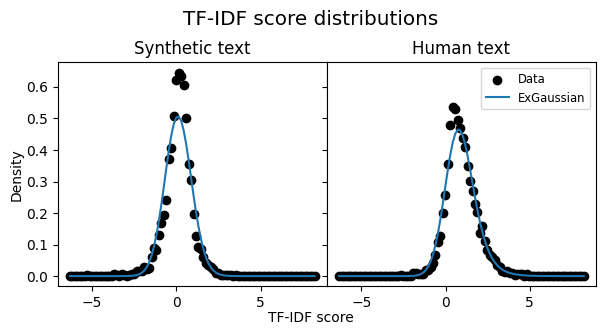

In [15]:
fig, axs = plt.subplots(
    1,
    2,
    figsize = (6, 3),
    sharex = 'col',
    sharey = 'row',
    tight_layout = True,
    gridspec_kw = {'wspace':0, 'hspace':0}
)

axs[0].set_title('Synthetic text')
axs[0].scatter(bin_centers, synthetic_density, color = 'black', label = 'Data')
axs[0].plot(bin_centers, synthetic_exponnorm_fit, label = 'ExGaussian')

axs[1].set_title('Human text')
axs[1].scatter(bin_centers, human_density, color = 'black', label = 'Data')
axs[1].plot(bin_centers, human_exponnorm_fit, label = 'ExGaussian')

axs[1].legend(
    loc = 'upper right',
    fontsize = 'small'
)

# Set figure title
fig.text(0.5, 1, 'TF-IDF score distributions', ha = 'center', fontsize = 'x-large')

# Set single label for shared x
fig.text(0.5, 0.01, 'TF-IDF score', ha = 'center')

# Set single label for shared y
fig.text(0.01, 0.5, 'Density', va = 'center', ha = 'center', rotation = 90)

plt.show()

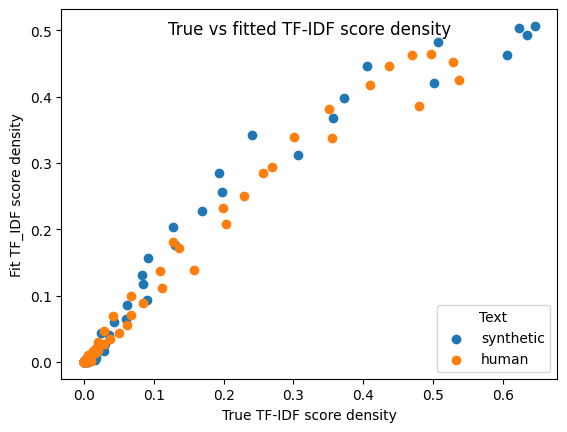

In [16]:
plt.title('True vs fitted TF-IDF score density', y = 1.0, pad = -18)
plt.scatter(synthetic_density, synthetic_exponnorm_fit, label = 'synthetic')
plt.scatter(human_density, human_exponnorm_fit, label = 'human')
plt.legend(title = 'Text', loc = 'lower right')
plt.xlabel('True TF-IDF score density')
plt.ylabel('Fit TF_IDF score density')
plt.show()

OK, looks good enough

In [17]:
def kl_divergence(p, q):
    
    '''Takes two lists, calculates KD divergence'''
    return [p[i] * log2(p[i]/q[i]) for i in range(len(p))]

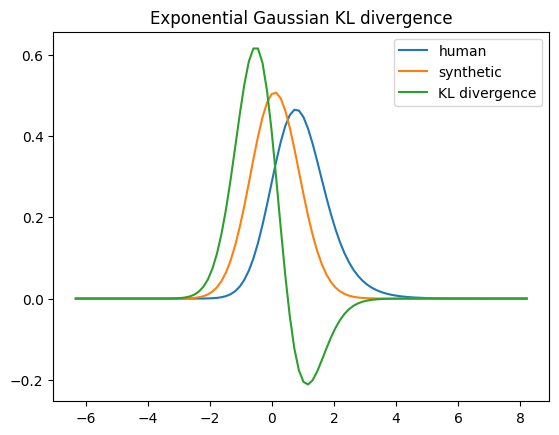

In [18]:
plt.title('Exponential Gaussian KL divergence')
plt.plot(bin_centers, human_exponnorm_fit, label = 'human')
plt.plot(bin_centers, synthetic_exponnorm_fit, label = 'synthetic')
plt.plot(bin_centers, kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit), label = 'KL divergence')
plt.legend(loc = 'upper right')
plt.show()

Sweet - I think we got it! Now, similarly to how we handled perplexity ratio score, we need a probability density function for the Kullback-Leibler divergence distribution. To do that - we need a kernel density estimate, and to do that - we need to reconstruct KL scores that would give the observed distribution.

In [19]:
# Get a kernel density estimate of the KL divergence so we can use the
# associated probability density function to convert perplexity ratio scores
# into KL scores

# Get a list of points covering the range of score values
tfidf_scores = fragment_scores['human'] + fragment_scores['synthetic']
x = np.arange(min(tfidf_scores) - 2, max(tfidf_scores) + 2, 0.01).tolist()
print(f'Will calculate {len(x)} fitted values')

# Do the exponential gaussian fits and get values for f(x)
bounds = [[-10.0,10.0],[-10.0,10.0],[-10.0,10.0]]

human_exponnorm = fit(exponnorm, fragment_scores['human'], bounds = bounds)
human_exponnorm_fit = exponnorm(human_exponnorm.params.K, human_exponnorm.params.loc, human_exponnorm.params.scale).pdf(x)

synthetic_exponnorm = fit(exponnorm, fragment_scores['synthetic'], bounds = bounds)
synthetic_exponnorm_fit = exponnorm(synthetic_exponnorm.params.K, synthetic_exponnorm.params.loc, synthetic_exponnorm.params.scale).pdf(x)

# Calculate the KL divergence of the fitted values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)

print(f'Have {len(kl)} KL divergence values')

Will calculate 1867 fitted values
Have 1867 KL divergence values


Min KL count value 0
Max KL count value: 80


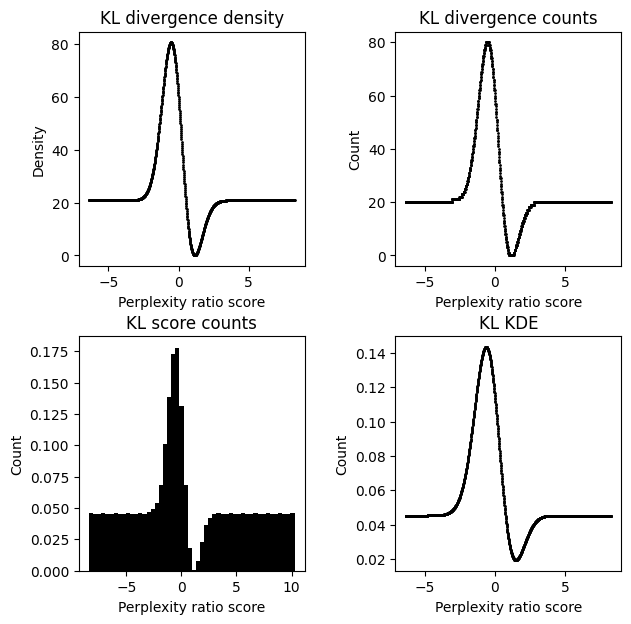

In [20]:
# Convert the kl 'density' values into integer 'count' values
kl = kl_divergence(synthetic_exponnorm_fit, human_exponnorm_fit)
kl = kl + abs(min(kl))
kl = kl * 100
kl_counts = [int(density) for density in kl]

print(f'Min KL count value {min(kl_counts)}')
print(f'Max KL count value: {max(kl_counts)}')

# Now, construct a list where each value of x appears a number of times
# equal to it's kl 'count'
kl_scores = []

for i in range(len(kl_counts)):
    kl_scores.extend([x[i]] * kl_counts[i])

# Finally, run a KDE on the reconstructed KL scores
kl_kde = gaussian_kde(kl_scores)

# And use it's PDF to get density for x after re-clipping x to the
# range of the original data
clipped_x = []
clipped_kl = []
clipped_kl_counts = []

for i, j in enumerate(x):
    if j > min(tfidf_scores) and j < max(tfidf_scores):
        clipped_x.append(j)
        clipped_kl.append(kl[i])
        clipped_kl_counts.append(kl_counts[i])

clipped_kl_kde_values = kl_kde.pdf(clipped_x)

fig, axs = plt.subplots(
    2,
    2,
    figsize = (7, 7),
    gridspec_kw = {'wspace':0.4, 'hspace':0.3}
)

axs[0,0].set_title('KL divergence density')
axs[0,0].scatter(clipped_x, clipped_kl, color='black', s = 1)
axs[0,0].set_xlabel('Perplexity ratio score')
axs[0,0].set_ylabel('Density')

axs[0,1].set_title('KL divergence counts')
axs[0,1].scatter(clipped_x, clipped_kl_counts, color='black', s = 1)
axs[0,1].set_xlabel('Perplexity ratio score')
axs[0,1].set_ylabel('Count')

axs[1,0].set_title('KL score counts')
axs[1,0].hist(kl_scores, bins = 50, color='black', density = True)
axs[1,0].set_xlabel('Perplexity ratio score')
axs[1,0].set_ylabel('Count')

axs[1,1].set_title('KL KDE')
axs[1,1].scatter(clipped_x, clipped_kl_kde_values, color='black', s = 1)
axs[1,1].set_xlabel('Perplexity ratio score')
axs[1,1].set_ylabel('Count')

plt.show()

OK, cool. Looks good. Now we need to TF-IDF score the fragments from the Hans 2024 corpus, and run the scores though the KL KDE's PDF and add the result to the dataframe.

In [21]:
def score_text_fragments(data_df: pd.DataFrame, tfidf_luts: dict = None) -> dict:
    '''Scores text fragments, returns human and synthetic TF-IDF and product 
    normalized difference in log2 TF-IDF mean'''

    # Holders for new features
    tfidf_scores = []
    human_tfidf = []
    synthetic_tfidf = []

    # Loop on dataframe rows
    for _, row in data_df.iterrows():
        
        human_tfidf_sum = 0
        synthetic_tfidf_sum = 0

        # Get the text from this row
        text = row['String']

        # Clean the text
        text = clean_text(text)

        # Split the text into words
        words = text.split(' ')

        # Score the words using the human and synthetic luts
        for word in words:

            if word in tfidf_luts['human'].keys():
                human_tfidf_sum += tfidf_luts['human'][word]

            if word in tfidf_luts['synthetic'].keys():
                synthetic_tfidf_sum += tfidf_luts['synthetic'][word]

        # Get the means
        human_tfidf_mean = human_tfidf_sum / len(words)
        synthetic_tfidf_mean = synthetic_tfidf_sum / len(words)
        dmean_tfidf = human_tfidf_mean - synthetic_tfidf_mean
        product_normalized_dmean_tfidf = dmean_tfidf * (human_tfidf_mean + synthetic_tfidf_mean)

        human_tfidf.append(human_tfidf_mean)
        synthetic_tfidf.append(synthetic_tfidf_mean)
        tfidf_scores.append(product_normalized_dmean_tfidf)

    return {'human_tfidf': human_tfidf, 'synthetic_tfidf': synthetic_tfidf, 'tfidf_score': tfidf_scores}

In [22]:
# Score the training fragments and add new features back to dataframe
fragment_scores = score_text_fragments(training_data_df, tfidf_luts)

training_data_df['Human TF-IDF'] = fragment_scores['human_tfidf']
training_data_df['Synthetic TF-IDF'] = fragment_scores['synthetic_tfidf']
training_data_df['TF-IDF score'] = fragment_scores['tfidf_score']

In [23]:
# Get KL score and add to dataframe
kl_scores = kl_kde.pdf(fragment_scores['tfidf_score'])
training_data_df['TF-IDF Kullback-Leibler score'] = kl_scores

training_data_df.head()
print()
training_data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 12716 entries, 0 to 12715
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  12716 non-null  int64  
 1   Fragment length (tokens)                 12716 non-null  int64  
 2   Dataset                                  12716 non-null  object 
 3   Source                                   12716 non-null  object 
 4   String                                   12716 non-null  object 
 5   Perplexity                               12716 non-null  float64
 6   Cross-perplexity                         12716 non-null  float64
 7   Perplexity ratio score                   12716 non-null  float64
 8   Perplexity ratio Kullback-Leibler score  12716 non-null  float64
 9   Human TF-IDF                             12716 non-null  float64
 10  Synthetic TF-IDF                         12716 non

Re-plot just to be sure we got the result we expected:

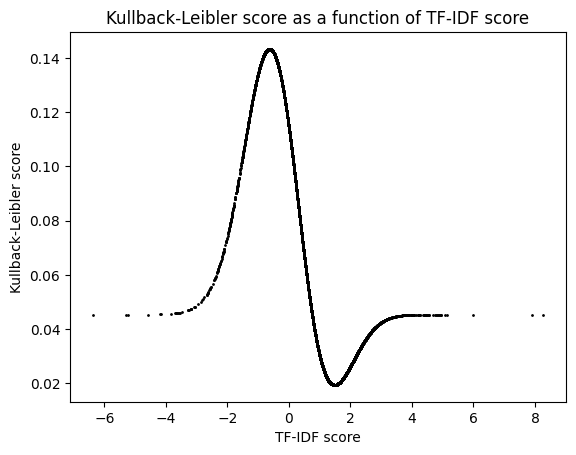

In [24]:
plt.title('Kullback-Leibler score as a function of TF-IDF score')
plt.scatter(training_data_df['TF-IDF score'], training_data_df['TF-IDF Kullback-Leibler score'], color = 'black', s = 1)
plt.xlabel('TF-IDF score')
plt.ylabel('Kullback-Leibler score')
plt.show()

Nailed it! Save for the next step.

In [25]:
# Save as JSON for later use
output_file = config.COMBINED_SCORED_HANS_TRAINING_DATA_PR_TFIDF

with open(output_file, 'w') as file:
    file.write(training_data_df.to_json())

Now do the same thing with the testing data, using the KL PDF derived from the training data.

In [26]:
# Load the data testing data
testing_data_df = pd.read_json(config.COMBINED_SCORED_HANS_TESTING_DATA_PR)

# Replace and remove string 'OOM' and 'NAN' values
testing_data_df.replace('NAN', np.nan, inplace = True)
testing_data_df.replace('OOM', np.nan, inplace = True)
testing_data_df.dropna(inplace = True)

# Fix some d-types
testing_data_df = testing_data_df.astype({
    'Fragment length (tokens)': int, 
    'Perplexity': float,
    'Cross-perplexity': float,
    'Perplexity ratio score': float
})

fragment_scores = score_text_fragments(testing_data_df, tfidf_luts)

testing_data_df['Human TF-IDF'] = fragment_scores['human_tfidf']
testing_data_df['Synthetic TF-IDF'] = fragment_scores['synthetic_tfidf']
testing_data_df['TF-IDF score'] = fragment_scores['tfidf_score']

# Get KL score and add to dataframe
kl_scores = kl_kde.pdf(fragment_scores['tfidf_score'])
testing_data_df['TF-IDF Kullback-Leibler score'] = kl_scores

output_file = config.COMBINED_SCORED_HANS_TESTING_DATA_PR_TFIDF

with open(output_file, 'w') as file:
    file.write(testing_data_df.to_json())

testing_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3179 entries, 0 to 3178
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Fragment length (words)                  3179 non-null   int64  
 1   Fragment length (tokens)                 3179 non-null   int64  
 2   Dataset                                  3179 non-null   object 
 3   Source                                   3179 non-null   object 
 4   String                                   3179 non-null   object 
 5   Perplexity                               3179 non-null   float64
 6   Cross-perplexity                         3179 non-null   float64
 7   Perplexity ratio score                   3179 non-null   float64
 8   Perplexity ratio Kullback-Leibler score  3179 non-null   float64
 9   Human TF-IDF                             3179 non-null   float64
 10  Synthetic TF-IDF                         3179 non-nul

Finally, save the Kullback–Leibler kernel density estimate for future use.

In [27]:
from pickle import dump

output_file = config.TFIDF_KL_KDE

with open(output_file, 'wb') as file:
    dump(kl_kde, file, protocol = 5)